In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import log_loss
import pickle

In [2]:
dir_out = 'data'

In [3]:
datadir = 'data_ori'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                      index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [4]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

## Brand and model features

In [5]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))



Brand features: train shape (74645, 131), test shape (112071, 131)


In [6]:
# Save features
with open(os.path.join(dir_out, 'features_bag_brand_train.pickle'), 'wb') as f:
    pickle.dump(Xtr_brand, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(dir_out, 'features_bag_brand_test.pickle'), 'wb') as f:
    pickle.dump(Xte_brand, f, pickle.HIGHEST_PROTOCOL)

In [7]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [8]:
# Save features
with open(os.path.join(dir_out, 'features_bag_model_train.pickle'), 'wb') as f:
    pickle.dump(Xtr_model, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(dir_out, 'features_bag_model_test.pickle'), 'wb') as f:
    pickle.dump(Xte_model, f, pickle.HIGHEST_PROTOCOL)

## Installed apps features

In [9]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
print deviceapps.shape
deviceapps.head()

(2369025, 5)


,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN


In [10]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [11]:
# Save features
with open(os.path.join(dir_out, 'features_bag_app_installed_train.pickle'), 'wb') as f:
    pickle.dump(Xtr_app, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(dir_out, 'features_bag_app_installed_test.pickle'), 'wb') as f:
    pickle.dump(Xte_app, f, pickle.HIGHEST_PROTOCOL)

In [12]:
# Remember devices that have events
trainrows_with_events = deviceapps.dropna(subset=['trainrow']).trainrow.unique().astype(int)
testrows_with_events = deviceapps.dropna(subset=['testrow']).testrow.unique().astype(int)
print 'Train:',trainrows_with_events.shape
print 'Test:',testrows_with_events.shape

Train: (23290,)
Test: (35172,)


In [13]:
print trainrows_with_events[1:20]
print testrows_with_events[1:20]

[27155 31158 74103 33759 72531 58566  3519 48415 55268 38547 34907 44950
 71390 36661 37160 50202 11817 32842 43795]
[ 10825 106929  35716  12532   2366  83094  97141  62416  72062  73108
  44944  71869  37215  60741  40298  77869 109642  58667  43799]


## Active apps features

In [14]:
deviceactiveapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['is_active'].agg(['sum'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
print deviceactiveapps.shape
deviceactiveapps.head()

(2369025, 5)


,device_id,app,sum,trainrow,testrow
0,-9222956879900151005,548,4.0,21594.0,NaN
1,-9222956879900151005,1096,0.0,21594.0,NaN
2,-9222956879900151005,1248,15.0,21594.0,NaN
3,-9222956879900151005,1545,2.0,21594.0,NaN
4,-9222956879900151005,1664,0.0,21594.0,NaN


In [15]:
deviceactiveapps['sum'] = deviceactiveapps['sum'].div(deviceapps['size'])
deviceactiveapps.head()

,device_id,app,sum,trainrow,testrow
0,-9222956879900151005,548,0.222222,21594.0,NaN
1,-9222956879900151005,1096,0.000000,21594.0,NaN
2,-9222956879900151005,1248,0.576923,21594.0,NaN
3,-9222956879900151005,1545,0.166667,21594.0,NaN
4,-9222956879900151005,1664,0.000000,21594.0,NaN


In [16]:
d = deviceactiveapps.dropna(subset=['trainrow'])
Xtr_act_app = csr_matrix((d['sum'], (d.trainrow, d.app)), 
                          shape=(gatrain.shape[0],napps))
d = deviceactiveapps.dropna(subset=['testrow'])
Xte_act_app = csr_matrix((d['sum'], (d.testrow, d.app)), 
                        shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_act_app.shape, Xte_act_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [17]:
# Save features
with open(os.path.join(dir_out, 'features_bag_app_active_train.pickle'), 'wb') as f:
    pickle.dump(Xtr_act_app, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(dir_out, 'features_bag_app_active_test.pickle'), 'wb') as f:
    pickle.dump(Xte_act_app, f, pickle.HIGHEST_PROTOCOL)

## App labels features

In [18]:
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [21]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
print(devicelabels.shape)
devicelabels.head()

(4244113, 5)


,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN
2,-9222956879900151005,126,1,21594.0,NaN
3,-9222956879900151005,138,2,21594.0,NaN
4,-9222956879900151005,147,2,21594.0,NaN


In [20]:
d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


In [21]:
# Save features
with open(os.path.join(dir_out, 'features_bag_label_installed_train.pickle'), 'wb') as f:
    pickle.dump(Xtr_label, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(dir_out, 'features_bag_label_installed_test.pickle'), 'wb') as f:
    pickle.dump(Xte_label, f, pickle.HIGHEST_PROTOCOL)

## Combine features

In [128]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 21527), test shape (112071, 21527)


In [69]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [70]:
def score(clf, random_state = 0):
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])))
    print('')
    return log_loss(y, pred)

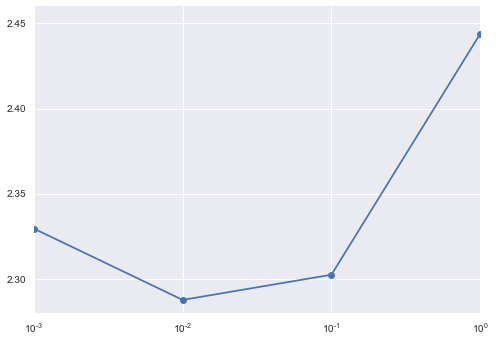

In [19]:
Cs = np.logspace(-3,0,4)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.semilogx(Cs, res,'-o');

In [71]:
print score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'))


2.2745185044


In [35]:
# Train on all devices
pred = np.zeros((y.shape[0], nclasses))

clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs')
clf.fit(Xtrain, y)
pred = pd.DataFrame(clf.predict_proba(Xtest), index = gatest.index, columns=targetencoder.classes_)
pred.head()

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.001424,0.005998,0.013605,0.013286,0.025313,0.046103,0.011815,0.033501,0.074615,0.121405,0.260537,0.392400
-1547860181818787117,0.007414,0.013299,0.031228,0.058677,0.072686,0.151391,0.006009,0.091906,0.054989,0.077066,0.229204,0.206130
7374582448058474277,0.023158,0.036713,0.036233,0.158343,0.162774,0.079852,0.012986,0.026441,0.043571,0.104941,0.181501,0.133486
-6220210354783429585,0.003474,0.030860,0.008801,0.012351,0.050697,0.172943,0.048150,0.139719,0.073499,0.093593,0.179861,0.186053
-5893464122623104785,0.046952,0.065640,0.042578,0.062522,0.056329,0.043467,0.090625,0.165219,0.097877,0.102350,0.132938,0.093503


In [36]:
pred.to_csv('logreg_subm.csv',index=True)

### Train on devices with events only

In [ ]:
Xtrain = Xtrain[trainrows_with_events,:]
y = y[trainrows_with_events]
print score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'))

In [37]:
# Train only on devices with events
# This led to a slightly worse score (+0.0001)
y = targetencoder.transform(gatrain.group)
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

Xtrain = Xtrain[trainrows_with_events,:]
Xtest = Xtest[testrows_with_events,:]
y = y[trainrows_with_events]
#print score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'))

# Train on all devices
pred = np.zeros((y.shape[0], nclasses))

clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs')
clf.fit(Xtrain, y)
pred = pd.DataFrame(clf.predict_proba(Xtest), index = gatest.index[testrows_with_events], columns=targetencoder.classes_)
pred = pred.reindex(gatest.index, fill_value=0)
pred.head()

All features: train shape (74645, 21527), test shape (112071, 21527)


,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.001492,0.005908,0.012127,0.012823,0.026008,0.043189,0.011091,0.027077,0.074270,0.111487,0.250954,0.423574
-1547860181818787117,0.006903,0.012172,0.023050,0.066971,0.078409,0.188372,0.004520,0.068493,0.036542,0.063060,0.238333,0.213175
7374582448058474277,0.024959,0.036950,0.037317,0.163299,0.161039,0.081345,0.012359,0.026086,0.042070,0.104421,0.177660,0.132494
-6220210354783429585,0.003754,0.029205,0.009505,0.012574,0.049471,0.188668,0.046326,0.126026,0.075881,0.086568,0.165567,0.206456
-5893464122623104785,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
pred.to_csv('logreg_subm_with_events.csv',index=True)

### Add extra features

In [100]:
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

In [101]:
# Adding geo features
feat_geo = pd.read_csv(os.path.join(dir_out,'features_geo.csv'))
feat_geo_tr = gatrain.merge(feat_geo, right_on='device_id', left_index=True, how='left')
feat_geo_te = gatest.merge(feat_geo, right_on='device_id', left_index=True, how='left')
feat_geo_tr.fillna(0, inplace=True)
feat_geo_te.fillna(0, inplace=True)
print feat_geo_tr.shape
feat_geo_tr.head()

(74645, 32)


,gender,age,group,trainrow,brand,model,device_id,dist_beijing,close_to_beijing,dist_guangzhou,...,close_to_nanjing,dist_wuhan,close_to_wuhan,dist_shanghai,close_to_shanghai,dist_harbin,close_to_harbin,dist_chongqing,close_to_chongqing,travel_dist
30673,M,35,M32-38,0,51,843,-8.076088e+18,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30673,M,35,M32-38,1,51,843,-2.897162e+18,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30673,M,35,M32-38,2,51,843,-8.260684e+18,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30673,M,30,M29-31,3,51,865,-4.938849e+18,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30673,M,30,M29-31,4,51,847,2.451335e+17,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
feat_geo_include = ['close_to_guangzhou', 'close_to_nanjing', 'close_to_harbin', 'close_to_chongqing']

In [103]:
Xtr_geo = csr_matrix(feat_geo_tr[feat_geo_include].values)
Xte_geo = csr_matrix(feat_geo_te[feat_geo_include].values)

Xtr_geo.shape

(74645, 4)

In [106]:
# Adding event features
feat_events = pd.read_csv(os.path.join(dir_out,'features_event.csv'))

# Extreme values
feat_events['n event hour max'][feat_events['n event hour max']>500]=500

for c in feat_events.columns[1:]:
    feat_events[c] = np.log(feat_events[c])
    feat_events[c] = normalize(feat_events[c])
    
feat_events_tr = gatrain.merge(feat_events, right_on='device_id', left_index=True, how='left')
feat_events_tr.fillna(0, inplace=True)

feat_events_te = gatest.merge(feat_events, right_on='device_id', left_index=True, how='left')
feat_events_te.fillna(0, inplace=True)

print feat_events_tr.shape
feat_events_tr.head()

(74645, 16)


/Users/joostbloom/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gender,age,group,trainrow,brand,model,device_id,n day events,n hour events,n event sum,n event day max,n event day mean,n event day std,n event hour max,n event hour mean,n event hour std
60864,M,35,M32-38,0,51,843,-8.076088e+18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60864,M,35,M32-38,1,51,843,-2.897162e+18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59075,M,35,M32-38,2,51,843,-8.260684e+18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60864,M,30,M29-31,3,51,865,-4.938849e+18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60864,M,30,M29-31,4,51,847,2.451335e+17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
feat_events_include = ['n day events', 'n event sum', 'n event day max']

In [108]:
Xtr_events = csr_matrix(feat_events_tr[feat_events_include].values)
Xte_events = csr_matrix(feat_events_te[feat_events_include].values)
Xtr_events.shape

(74645, 3)

In [137]:
print('Shape before {}'.format(Xtr_act_app.shape))
selector = VarianceThreshold(0.000001)
selector.fit(Xtr_act_app)
Xtr_act_app2 = selector.transform(Xtr_act_app)
Xte_act_app2 = selector.transform(Xte_act_app)
print('Shape after feature selection {}'.format(Xtr_act_app2.shape))

Shape before (74645, 19237)
Shape after feature selection (74645, 2135)


In [138]:

Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label, Xtr_geo, Xtr_events, Xtr_act_app2), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label, Xte_geo, Xte_events, Xte_act_app2), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 23669), test shape (112071, 23669)


In [133]:
print score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'))


2.27411249347


In [139]:
# Train on all devices
pred = np.zeros((y.shape[0], nclasses))

clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs')
clf.fit(Xtrain, y)
pred = pd.DataFrame(clf.predict_proba(Xtest), index = gatest.index, columns=targetencoder.classes_)
pred.head()

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.001289,0.004928,0.011339,0.011982,0.025924,0.045094,0.010954,0.026970,0.066801,0.114036,0.260222,0.420460
-1547860181818787117,0.006701,0.011075,0.027359,0.060812,0.077953,0.152517,0.004840,0.071422,0.058678,0.076714,0.241267,0.210662
7374582448058474277,0.021819,0.035673,0.032062,0.166387,0.160471,0.065827,0.014091,0.028257,0.042407,0.101265,0.185604,0.146137
-6220210354783429585,0.003240,0.029094,0.009028,0.011882,0.050864,0.192944,0.049351,0.126334,0.087813,0.095585,0.159666,0.184197
-5893464122623104785,0.046985,0.065538,0.042861,0.062404,0.056654,0.043127,0.089342,0.166455,0.099124,0.102042,0.132799,0.092668


In [140]:
pred.to_csv('logreg_subm_extra_features.csv',index=True)